In [1]:
from contextlib import contextmanager
from typing import Callable, List
from time import time
import functools

timing: List[float] = []
memory: List[int] = []

def reset():
    global timing
    global memory
    timing = []
    memory = []

def measure_and_compare(version: int):
    def decorator(func: Callable):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start = time()
            func()
            end = time()
            timespan = end - start
            if version == len(timing):
                timing.append(timespan)
            elif version < len(timing):
                print(f"Overwriting v{version} (was {timing[version]:.2f}s)")
                timing[version] = timespan
            else:
                raise ValueError(f"v{version} is too high, expected v{len(timing)}")
            timing[version] = end - start
            if version > 0:
                x_perc_faster = (timing[version-1] / timing[version]) - 1
                print(f"{timing[version]:7.2f}s, {x_perc_faster:.2%} faster (was {timing[version-1]:.2f}s)")
            else:
                print(f"{timing[version]:7.2f}s")
        wrapper()
        return wrapper
    return decorator

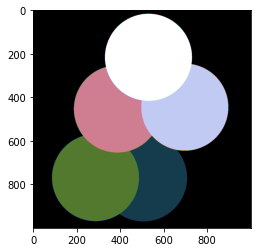

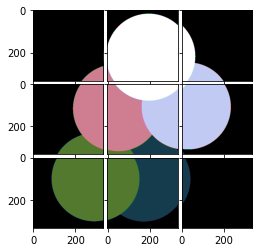

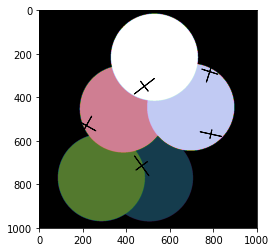

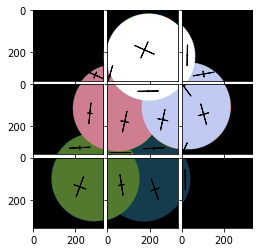

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

def get_segmentation(size=1000, segments=5, seed=1):
    segmentation = np.zeros((size, size), dtype="uint8")
    axis = np.linspace(0, 1, size)
    coords = np.stack(np.meshgrid(axis, axis), axis=-1)
    radius = 0.2
    rng = np.random.default_rng(seed)
    for segment in range(1, 1 + segments):
        center = rng.random(2) * (1 - 2 * radius) + radius
        mask = np.linalg.norm(coords - center, axis=2) < radius
        segmentation[mask] = segment
    return segmentation

def get_chunks(array, chunks=3, _axis=0):
    if array.ndim == _axis + 1:
        yield from np.array_split(array, chunks, axis=_axis)
    else:
        for i in np.array_split(array, chunks, axis=_axis):
            yield from get_chunks(i, chunks=chunks, _axis=_axis+1)

def get_center_and_covariance(segmentation):
    if isinstance(segmentation, list):
        return list(map(get_center_and_covariance, segmentation))
    axes = [np.linspace(0, 1, dim_len) for dim_len in segmentation.shape]
    coords = np.stack(np.meshgrid(*axes[::-1]), axis=-1)
    center_of_mass = {}
    covariance_matrix = {}
    for segment in range(1, 1 + segmentation.max()):
        mask = segmentation == segment
        if mask.sum() > 0:
            segment_coords = coords[mask]
            center_of_mass[segment] = np.mean(segment_coords, axis=0)
            covariance_matrix[segment] = np.cov(segment_coords.T)
    return center_of_mass, covariance_matrix

def plot(segmentation, center_and_covariance=None, _ax=None, _vmax=None):
    if isinstance(segmentation, list):
        side_len = int(math.sqrt(len(segmentation)))
        vmax = max(i.max() for i in segmentation)
        fig, axs = plt.subplots(side_len, side_len, sharex=True, sharey=True)
        fig.subplots_adjust(
            wspace=-0.6,
            hspace=0.05
        )
        for i, chunk in enumerate(chunked_segmentation):
            plot(
                chunk,
                center_and_covariance and center_and_covariance[i],
                _ax=axs[i//side_len, i%side_len],
                _vmax=vmax
            )
        plt.show()
    else:
        ax = _ax or plt
        ax.imshow(segmentation, "cubehelix", vmax=_vmax)
        if center_and_covariance is not None:
            center, covariance = center_and_covariance
            plt.xlim(0, segmentation.shape[0])
            plt.ylim(segmentation.shape[1], 0)
            for segment in center.keys():
                eigenvals, eigenvecs = np.linalg.eig(covariance[segment])
                scaled_eigenvecs = eigenvecs * eigenvals[:, None]
                scaled_eigenvecs *= 100 / np.linalg.norm(scaled_eigenvecs, axis=0).max()
                scaled_center = center[segment] * len(segmentation)
                for e in scaled_eigenvecs:
                    ax.arrow(*scaled_center - e / 2, *e, head_width=0)
        if _ax is None:
            plt.show()

segmentation = get_segmentation()
plot(segmentation)
chunked_segmentation = list(get_chunks(segmentation))
plot(chunked_segmentation)
center_and_covariance = get_center_and_covariance(segmentation.T)
plot(segmentation, center_and_covariance)
chunked_center_and_covariance = get_center_and_covariance(chunked_segmentation)
plot(chunked_segmentation, chunked_center_and_covariance)

In [3]:
from time import sleep

reset()

@measure_and_compare(0)
def v0():
    sleep(0.3)

@measure_and_compare(1)
def v1():
    sleep(0.1)

v1()

   0.30s
   0.10s, 199.34% faster (was 0.30s)
Overwriting v1 (was 0.10s)
   0.10s, 195.17% faster (was 0.30s)
